In [1]:
from generate_mdps import generate_datsets
from dataset import MDPDataset, AllNodeFeatures, InMemoryMDPDataset
from experiment import Experiment
from MDP_helpers import calculate_gap, multiclass_recall_score

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn.models import GCN
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import random_split
from collections import defaultdict
from sklearn.metrics import recall_score

from time import time
from tqdm import tqdm

/home/james/virtual_envs/csiro_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device='cpu'
print(device)

cuda


In [5]:
N_datasets = 100

N_sites = 5
N_species = 20
K = 7

N_states = 3**N_sites

generate_datsets(N_sites, N_species, K, N_datasets, remove_previous=False, folder="hparam_data")

'Data already exists'

In [6]:
dataset = InMemoryMDPDataset("datasets/hparam_data/", pre_transform=AllNodeFeatures())

In [7]:
torch.all(dataset[0].R == dataset[5].R)

tensor(False)

In [8]:
train_ratio = 0.8
test_ratio = 0.2

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])
train_data = DataLoader(train_set, batch_size=1, shuffle=True)
test_data = DataLoader(test_set, batch_size=1, shuffle=True)

In [9]:
best_params = {'score': 0.3005344048681545,
 'hidden_channels': 176.0,
 'num_layers': 1.0,
 'dropout': 0.004100687104164412,
 'lr': 2.698927286009522,
 'weight_decay': 0.0014830234258634764,
 'gamma': 0.9970183847892857}

In [137]:
N_epochs = 500

def objective(trial):
    # hidden_channels = trial.suggest_int("hidden_channels", 30, 200)
    # num_layers = trial.suggest_int("num_layers", 1, 3)
    # dropout = trial.suggest_float("dropout", 0, 0.1)
    lr = trial.suggest_float("lr", 2.52, 2.6)
    # weight_decay = trial.suggest_float("weight_decay", 1e-3, 1e-1)
    gamma = trial.suggest_float("gamma", 0.99975, 1)
    hidden_channels = 175
    num_layers = 1
    dropout = 0.005
    weight_decay = 0.001

    gcn_model = GCN(
        in_channels=dataset[0].x.shape[1], 
        out_channels=K, 
        hidden_channels=hidden_channels, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)


    optimizer = torch.optim.Adam(gcn_model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_function = torch.nn.CrossEntropyLoss()
    lr_sheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

    gcn_model.train()
    for epoch in range(N_epochs):
        optimizer.zero_grad()     
        loss = 0
        for data in train_data:
            pred = gcn_model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device)
            )
            loss += loss_function(pred, data.k_labels.to(device))
        loss.backward()
        optimizer.step()
        lr_sheduler.step()
    
    gcn_model.eval()
    errors = []
    recall = []
    for data in test_data:
        out = gcn_model(
                x = data.x.to(device), 
                edge_index=data.edges.to(device)
            )
        pred = F.softmax(out, dim=1).argmax(axis=1).to('cpu')

        _, error = calculate_gap(data.P, data.R, data.V, pred, K)
        errors.append(error.to('cpu'))
        recall.append(
            recall_score(data.k_labels.to('cpu'), pred.to('cpu'), average="macro")
        )
    
    return np.mean(recall), np.mean(errors) # Minimise errors while maximising recall score

study = optuna.create_study(directions=['maximize', 'minimize'])
study.optimize(objective, n_trials=100)

# best_params = study.best_params

# print(study.best_value)
# print(best_params)

[I 2023-10-29 16:56:26,027] A new study created in memory with name: no-name-750fbf29-b670-4c97-9b43-0a486b4604ba
[I 2023-10-29 16:57:27,353] Trial 0 finished with values: [0.6999536888170217, 0.39112454652786255] and parameters: {'lr': 2.5564787179181634, 'gamma': 0.9999269077656636}. 
[I 2023-10-29 16:58:27,626] Trial 1 finished with values: [0.6327696704036565, 0.30089646577835083] and parameters: {'lr': 2.580983915851568, 'gamma': 0.9998484011004589}. 
[I 2023-10-29 16:59:27,227] Trial 2 finished with values: [0.7223939468027065, 0.18981634080410004] and parameters: {'lr': 2.5313925430201065, 'gamma': 0.9998628396665051}. 
[I 2023-10-29 17:00:22,278] Trial 3 finished with values: [0.7622899097741929, 0.3975273370742798] and parameters: {'lr': 2.5256124726629428, 'gamma': 0.9999860945117612}. 
[I 2023-10-29 17:01:20,608] Trial 4 finished with values: [0.6754839636208991, 0.3800320029258728] and parameters: {'lr': 2.56841574944975, 'gamma': 0.9999007357880091}. 
[I 2023-10-29 17:02:1

In [138]:
trials = [i for i in map(lambda x: dict([("recall", x.values[0]), ("error", x.values[1]),*(x.params).items()]), study.get_trials())]
trials = pd.DataFrame(trials)
trials['diff'] = trials['recall'] - trials['error']
trials = trials.sort_values(by='diff', ascending=False)

In [ ]:
best_params = {'score': 0.3005344048681545,
 'hidden_channels': 176.0,
 'num_layers': 1.0,
 'dropout': 0.004100687104164412,
 'lr': 2.698927286009522,
 'weight_decay': 0.0014830234258634764,
 'gamma': 0.9970183847892857}

best_params = {
 'hidden_channels': 176,
 'num_layers': 1.0,
 'dropout': 0.005,
 'lr': 2.525942,
 'weight_decay': 0.001,
 'gamma': 0.999806}

In [139]:
trials

,recall,error,lr,gamma,diff
15,0.739561,0.135789,2.537556,0.999900,0.603772
65,0.729307,0.125704,2.525942,0.999806,0.603602
83,0.740074,0.151310,2.572685,0.999863,0.588764
25,0.716783,0.131142,2.594925,0.999906,0.585640
23,0.712321,0.133007,2.582039,0.999872,0.579314
...,...,...,...,...,...
19,0.467286,0.491980,2.562953,0.999951,-0.024694
34,0.058241,0.133415,2.558552,0.999987,-0.075174
31,0.047334,0.149311,2.578778,0.999869,-0.101977
73,0.044549,0.203992,2.594925,0.999895,-0.159443


In [140]:
trials = trials.drop_duplicates(["lr", "gamma"])

In [141]:
y = trials.gamma.unique()
x = trials.lr.unique()
Z = np.zeros((len(x), len(y))) 

for i in range(len(x)):
    for j in range(len(y)):
        df = trials[np.logical_and(trials.lr == x[i], trials.gamma == y[j])]
        if df.size == 0:
            pass
        else:
            Z[i, j] = df.error

/tmp/ipykernel_11428/320399372.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Z[i, j] = df.error


Text(0, 0.5, 'gamma')

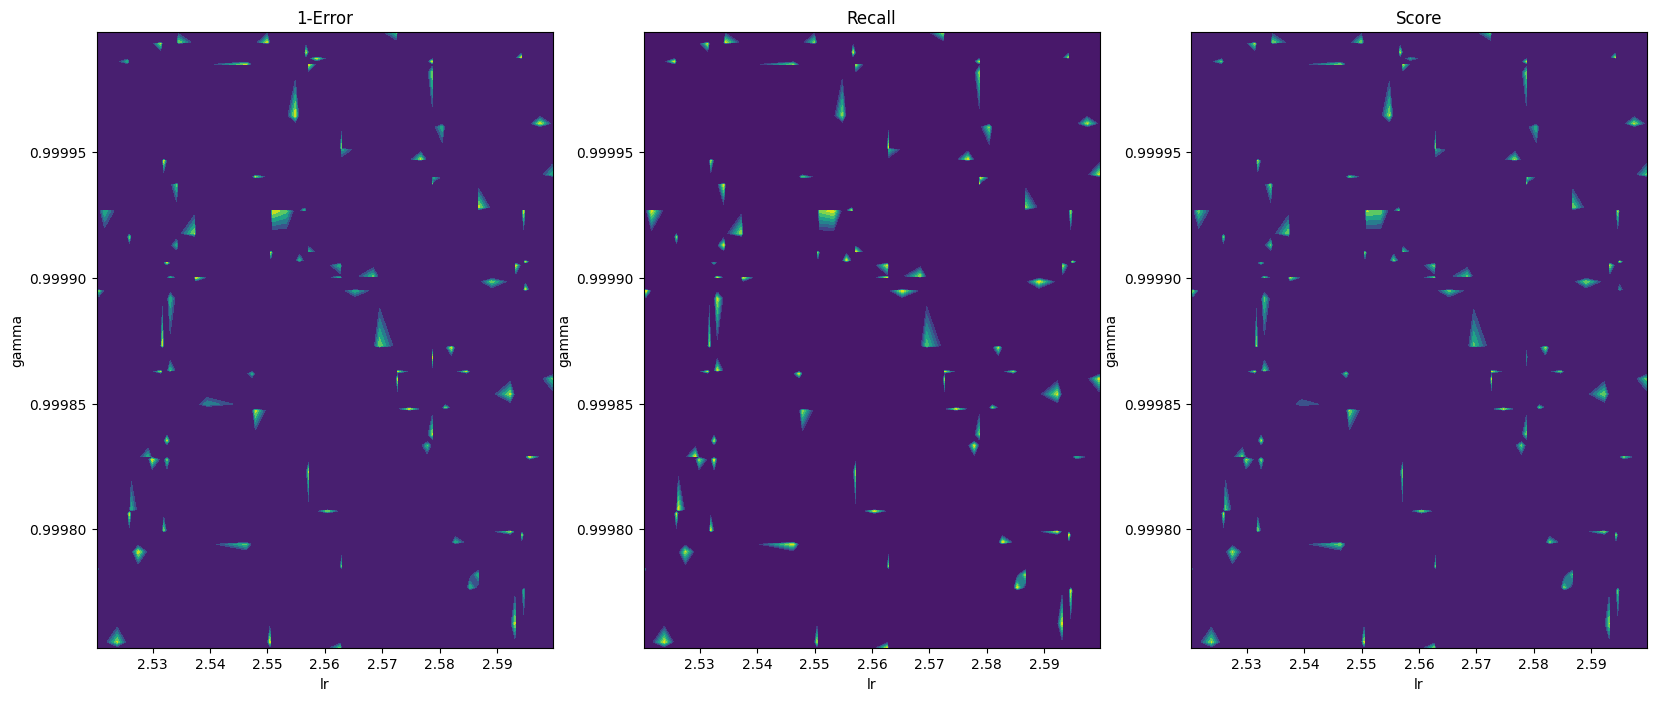

In [142]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))

df = trials.pivot(index = "lr", columns="gamma", values="error")
df = df.fillna(1)
X = df.index
Y = df.columns
Z = df.values.T
ax[0].set_title("1-Error")
ax[0].contourf(X, Y, 1-Z)
ax[0].set_xlabel("lr")
ax[0].set_ylabel("gamma")

df = trials.pivot(index = "lr", columns="gamma", values="recall")
df = df.fillna(0)
X = df.index
Y = df.columns
Z = df.values.T
ax[1].set_title("Recall")
ax[1].contourf(X, Y, Z)
ax[1].set_xlabel("lr")
ax[1].set_ylabel("gamma")

df = trials.pivot(index = "lr", columns="gamma", values="diff")
df = df.fillna(-1)
X = df.index
Y = df.columns
Z = df.values.T
ax[2].set_title("Score")
ax[2].contourf(X, Y, Z/2 + 0.5)
ax[2].set_xlabel("lr")
ax[2].set_ylabel("gamma")

<Axes: xlabel='lr'>

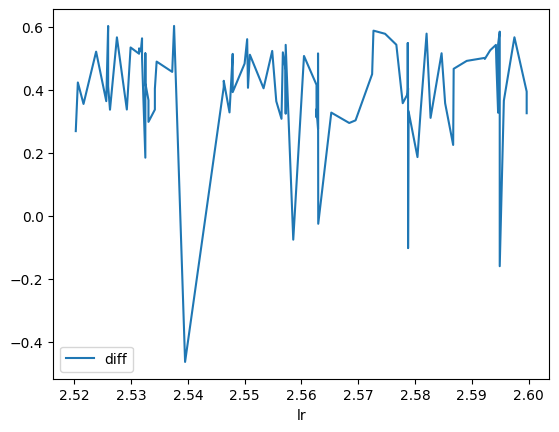

In [143]:
trials.sort_values(by="lr").plot(x="lr", y = "diff")

In [ ]:
# experiment = Experiment(savefile="gcn_hparams")
# for i in trials.index:
#     trials.loc[i].to_dict()
#     experiment.save(trials.loc[i].to_dict())

In [ ]:
# pd.DataFrame(experiment.load()).sort_values(by="score", ascending=False)